In [26]:
# load general packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import numba as nb

## Uncomment for nicer plots ##
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rc('axes', axisbelow=True)

Draw a lot from a Pareto Type II distribution

In [2]:
np.seed = 200

In [3]:
N = 10_000_000
alpha = 1.2
mu = -0.3

rand = np.random.uniform(0,1, size=N)
x = mu + (1 - rand)**(-1/alpha)

In [4]:
P = 0.005
u = np.percentile(x,100*(1-P))
u

82.23175118081943

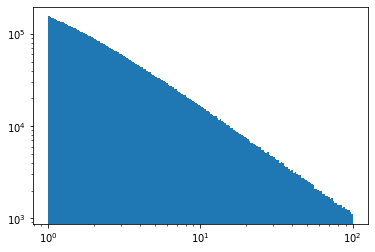

In [7]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.hist(x, bins = np.logspace(0,2,200))
ax.set(xscale='log', yscale = 'log')

plt.show()

In [8]:
# Compute u when P = 0.01
# i.e. the 99th percentile of the distribution
P = 0.01
u = np.percentile(x,100*(1-P))

# Compute S
x_low = x[x<u]
E_low = np.mean(x[x<u])
S = alpha/(alpha-1)*u*P / (alpha/(alpha-1)*u*P + E_low * (1-P))

In [9]:
# Compute Gini of top group
G_top = 1/(2*alpha-1)

In [196]:
## DELETE THESE ##

def gini(x):
    
    '''Compute Gini coefficient'''
    
    mad = np.abs(np.subtract.outer(x,x)).mean()
    rmad = mad/np.mean(x)
    g = 0.5 * rmad
    
    return g

@nb.njit(fastmath=True)
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

Optimal function for gini coefficient here

In [13]:
def gini(x, w=None):
    # The rest of the code requires numpy arrays.
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        # Force float dtype to avoid overflows
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        # The above formula, with all weights equal to 1 simplifies to:
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

In [14]:
# Compute Gini coefficient for low group
G_low = gini(x[x<u])

In [235]:
G_alt = gini_coefficient(x)

In [246]:
G = G_top*P*S + G_low*(1-P)*(1-S) + S - P

In [244]:
G_alt

0.5605639480673211

In [15]:
# Test loop
reps = 10_000
n = 100_000
u_vec = np.zeros(shape=reps)
ts_vec = np.zeros(shape=reps)

for rep in range(reps):
    
    # Draw values
    rand = np.random.uniform(0,1, size=n)
    x = mu + (1 - rand)**(-1/alpha)
    
    # Compute p
    P = 0.01
    u = np.percentile(x,100*(1-P))
    
    u_vec[rep] = u
    
    ts_vec[rep] = np.mean(x[x>=u]) / (np.mean(x[x>=u]) + np.mean(x[x<u]))

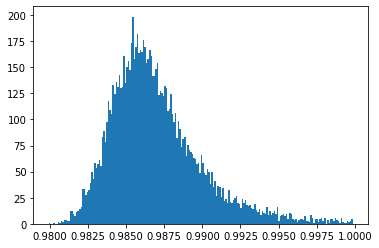

In [17]:
plt.hist(ts_vec, bins=200, density=True)
plt.show()

In [18]:
stats.kurtosis(u_vec)

0.09200495855607205

Monte Carlo experiment for the non-parametric and semi-parametric estimator

In [58]:
# alpha = 1.2
# mu = -0.0

reps = 10_000
n = 50_000

alpha = 1.5
mu = 0.0

G_vec = np.zeros(shape=reps)
G_nonparam_vec = np.zeros(shape=reps)
G_alvaredo_vec = np.zeros(shape=reps)

# Loop over replications for now
for rep in range(reps):
    
    # Draw values
    rand = np.random.uniform(0,1, size=n)
    x = mu - 1 + (1 - rand)**(-1/alpha)
    
    # Compute p
    P = 0.0025
    u = np.percentile(x,100*(1-P))
    
    # Compute S
    x_low = x[x<u] # Is this needed?
    E_low = np.mean(x[x<u])
    S = alpha/(alpha-1)*u*P / (alpha/(alpha-1)*u*P + E_low * (1-P))
    S_alvaredo = np.mean(x[x>=u]) / (np.mean(x[x>=u]) + E_low) # Numerical top income share

    # Compute the Gini coefficients with both methods
    G_high = 1/(2*alpha-1)
    G_low = gini(x[x<u])
    
    G = G_high*P*S + G_low*(1-P)*(1-S) + S - P
    G_nonparam = gini(x)
#     G_alvaredo = G_high*P*S_alvaredo + G_low*(1-P)*(1-S_alvaredo) + S_alvaredo - P
    
    # Save values
    G_vec[rep] = G
    G_nonparam_vec[rep] = G_nonparam
#     G_alvaredo_vec[rep] = G_alvaredo

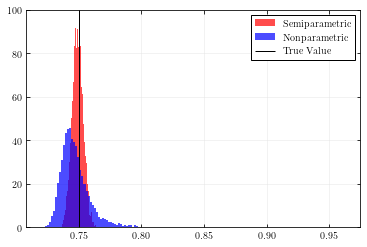

In [61]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1)

ax.grid(b=True, which = 'major', linestyle='-', linewidth=0.5, color='0.9', zorder=0)
ax.tick_params(axis='both', bottom=True, top=True, left=True, right=True, direction='in', which='both')

ax.hist(G_vec, density = True, bins = 150, color = 'red', alpha = 0.7, zorder = 2, label='Semiparametric')
ax.hist(G_nonparam_vec, density = True, bins = 150, color = 'blue', alpha = 0.7, zorder = 2, label='Nonparametric')
# ax.hist(G_alvaredo, density = True, bins = 150, color = 'green', alpha = 0.7, zorder = 2)

ax.vlines(G_true, ymin=0,ymax=100, linestyle = '-', linewidth = 1.0, label='True Value', zorder=3)
ax.set_ylim(0,100)
# ax.set_xlim(0.65,1)

ax.legend(frameon = True, edgecolor = 'k', facecolor = 'white', framealpha=1, fancybox=False)

plt.savefig('../../tex/figs/estimator_15.pdf')

In [45]:
print('Nonparam estimator = ' + str(np.mean(G_nonparam)))
print('Semiparam estimator = ' + str(np.mean(G_vec)))

Nonparam estimator = 0.7435334345540074
Semiparam estimator = 0.7493118631821546


In [395]:
# Lorenz curve for Pareto type II
def lorenz(F):
    
    denom = mu-1 + alpha /(alpha-1)
    nom = F*(mu-1) + alpha/(alpha-1)*(1-(1-F)**(1-1/alpha))
    
    return nom/denom

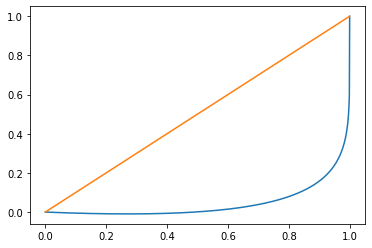

In [396]:
temp = np.linspace(0,1,1000)
lorenz_val = lorenz(temp)

plt.plot(temp,lorenz_val)
plt.plot(temp,temp)

In [60]:
mu = 0.00
alpha = 1.5
eta = mu-1 + alpha/(alpha-1)

G_true = 1 - 2/eta * ( (mu-1)/2 + alpha/(alpha-1)*(1 - alpha/(2*alpha-1)))
G_true

0.75

Compute Gini numerically

In [410]:
d = 1000000

vals = np.linspace(0,1,d)
dF = 1/d
lorenz_vals = lorenz(vals)

lorenz_int = np.sum(lorenz_vals*dF)

gini_num = 1 - 2*lorenz_int
gini_num

0.8623158058581297

It fits